In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from textblob import TextBlob
%matplotlib inline

In [6]:
ids = []
replies = []
likes = []
texts = []

with open("../data/comments/UScomments.csv", "r") as f:
    for line in f:
        l = line.split(",")
        ids.append(l[0])
        replies.append(l[-1][:-1])
        likes.append(l[-2])
        texts.append(','.join(l[1:-2])[1:-1])

In [7]:
df = pd.DataFrame({"video_id": ids[1:],
                   "replies": replies[1:],
                   "likes": likes[1:],
                   "texts": texts[1:]})

valid_indexes = []
for ix, r in df.iterrows():
    try:
        int(r.replies)
        int(r.likes)
        valid_indexes.append(ix)
    except:
        pass

df = df.loc[valid_indexes]

In [ ]:
df.loc[:, "likes"] = df.likes.astype(int)
df.loc[:, "replies"] = df.replies.astype(int)

df.loc[:, "sentiment"] = df.texts.apply(lambda x: TextBlob(x).sentiment)

df.loc[:, "polarity"] = df.sentiment.apply(lambda x: x[0])
df.loc[:, "subjectivity"] = df.sentiment.apply(lambda x: x[1])

df = df.drop(columns="sentiment")

df.to_csv("../data/comments/UScomments_clean.csv")

In [ ]:
ids = []
dates = []
with open("../data/comments/USvideos.csv", "r") as f:
    for line in f:
        l = line.split(",")
        ids.append(l[0])
        dates.append(l[-1][:-1])

In [ ]:
vid_dates = pd.DataFrame({"video_id": ids[1:], "date": dates[1:]}).set_index("video_id")

In [ ]:
dates = vid_dates.join(df.groupby("video_id").polarity.mean()).dropna()
dates = dates.groupby("date").polarity.mean().reset_index()
dates.loc[:, "date"] = pd.to_datetime(dates.date + ".17", format="%d.%m.%y")

dates.set_index("date").plot(figsize=(16, 6), linewidth=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig("plots/sentiment.png", bbox_inches="tight")

In [ ]:
pos_dates = vid_dates.join(df[df.polarity>0].groupby("video_id").polarity.mean()).dropna()
pos_dates = pos_dates.groupby("date").polarity.mean().reset_index()
pos_dates.loc[:, "date"] = pd.to_datetime(pos_dates.date + ".17", format="%d.%m.%y")

pos_dates.set_index("date").plot();

In [ ]:
neg_dates = vid_dates.join(df[df.polarity<0].groupby("video_id").polarity.mean()).dropna()
neg_dates = neg_dates.groupby("date").polarity.mean().reset_index()
neg_dates.loc[:, "date"] = pd.to_datetime(neg_dates.date + ".17", format="%d.%m.%y")

neg_dates.set_index("date").plot();

In [109]:
df.loc[:, "polsub"] = df.polarity*df.subjectivity

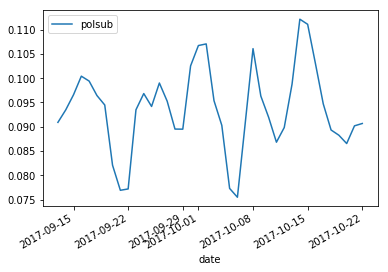

In [111]:
dates = vid_dates.join(df.groupby("video_id").polsub.mean()).dropna()
dates = dates.groupby("date").polsub.mean().reset_index()
dates.loc[:, "date"] = pd.to_datetime(dates.date + ".17", format="%d.%m.%y")

dates.set_index("date").plot();

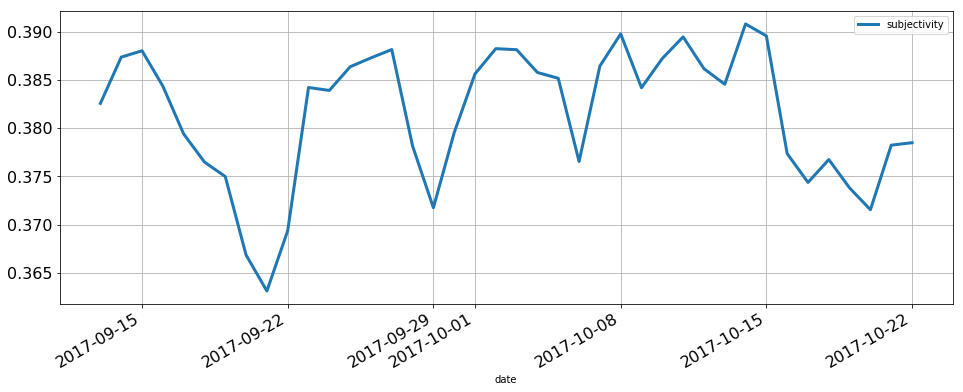

In [202]:
dates = vid_dates.join(df.groupby("video_id").subjectivity.mean()).dropna()
dates = dates.groupby("date").subjectivity.mean().reset_index()
dates.loc[:, "date"] = pd.to_datetime(dates.date + ".17", format="%d.%m.%y")

dates.set_index("date").plot(figsize=(16, 6), linewidth=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig("plots/subjectivity.png", bbox_inches="tight")

In [179]:
dates = vid_dates.join(df.groupby("video_id").polarity.aggregate([np.mean, np.std])).dropna()

def combine_dates(group):
    group = group.rename(columns={"mean": "m", "std": "s"})
    new_mean = group.m.mean()
    new_std = np.sqrt(np.sum(group.s.apply(lambda x: x**2)))
    date = group.date.iloc[0]
    return pd.DataFrame({"m": new_mean, "s": new_std}, index=[date])
dates = dates.groupby("date").apply(combine_dates)
dates.index = dates.index.levels[0]
dates = dates.reset_index()

In [180]:
dates.loc[:, "date"] = pd.to_datetime(dates.date + ".17", format="%d.%m.%y")
dates = dates.set_index("date").sort_index()

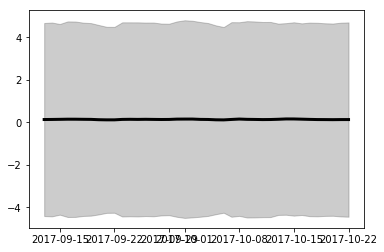

In [181]:
plt.fill_between(dates.index, dates.m-dates.s, dates.m+dates.s, alpha=0.2, color='k');
plt.plot(dates.m, linewidth=3, color='k');